# Простой анализ паблика Newочём
 
В этом простеньком исследовании будет обсуждаться паблик [Newочём](https://vk.com/newochem), в котором пользователи в регулярном голосовании выбирают, какую англоязычную актуальную статью они бы хотели прочитать в переводе, а редакторы и переводчики сообщества ее переводят.

Я постараюсь собрать данные со всех голосований и проверить свою гипотезу о том, что 
> при достаточно длинном описании всех вариантов голосования многие участники не могут прочитать все варианты внимательно,
> или их внимание убывает от первого варианта к последнему и по этой причине они чаще всего выбирают первый вариант, который в итоге побеждает

Эту гипотезу и ее анализ не стоит воспринимать слишком серьезно - для корректной ее проверки необходимо проводить дополнительные эксперименты. Гипотеза возникла из-за моего постоянного участия в голосовании и от удивления, что так часто побеждает первый вариант. 

Также будет проведен анализ того, какие источники статей более ценимы сообществом и существуют ли слова, при наличии которых участники более охотно голосуют за вариант.

Все исследование на python.

In [1]:
import requests as rq
import datetime as dt
import time
import json
import pandas as pd
import pymorphy2
import pylab as plt
import numpy as np

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
#следует ли по новой выгружать данные - минут 10 это занимает
download_data = False

In [3]:
foundation = dt.datetime.strptime('16 11 2014', '%d %m %Y') #дата основания паблика

Для загрузки постов используется один единственный метод VK API - а именно wall.get:
https://new.vk.com/dev/wall.get

In [4]:
response = rq.get('https://api.vk.com/method/wall.get?', params={'owner_id' : '-80512191', 'filter' : 'owner', 
                                                                 'count' : 10, 'offset' : 0, 'v' : '5.52'})
response

<Response [200]>

In [5]:
def download_newochem_data():
    raw_data = []
    skip = 0
    chunksize = 10
    date = dt.datetime.now()
    while date > foundation:
        response = rq.get('https://api.vk.com/method/wall.get?', params={'owner_id' : '-80512191', 'filter' : 'owner', 
                                                                     'count' : chunksize, 'offset' : skip, 'v' : '5.52'})
        if response.ok and response.json()['response']['items']:
            date = dt.datetime.fromtimestamp(response.json()['response']['items'][-1]['date'])
            raw_data.append(response.json())
        else:
            break
        time.sleep(4)
        skip += chunksize
    return raw_data

In [6]:
%%time

if download_data:
    raw_data = download_newochem_data()

Wall time: 8min 38s


In [10]:
#парсим наши данные и сохраняем их на диск
if download_data:
    items = []
    for entry in raw_data:
        for item in entry['response']['items']:
            items.append(item)
    with open('data.json', 'w') as outfile:
        data = {'items':items}
        json.dump(data, outfile)

In [11]:
#или достаем с диска
if not download_data:
    with open('data.json', 'r') as fp:
        data = json.load(fp)

In [13]:
print 'Всего загружено на стене постов: ', len(data['items'])

Всего загружено на стене постов:  1206


In [14]:
#находим среди этих постов только голосования
polls = []
for item in data['items']:
    date = dt.datetime.fromtimestamp(item['date'])
    if 'attachments' in item.keys():
        for attach in item['attachments']:
            if attach['type'] == 'poll':
                polls.append((date, attach, item))

In [15]:
print 'Всего проведено голосований: ', len(polls)

Всего проведено голосований:  395


Все, данные извлечены, теперь можно с ними работать. В качестве затравки можно посмотреть, как росло количество участников в опросах с начала основания группы:

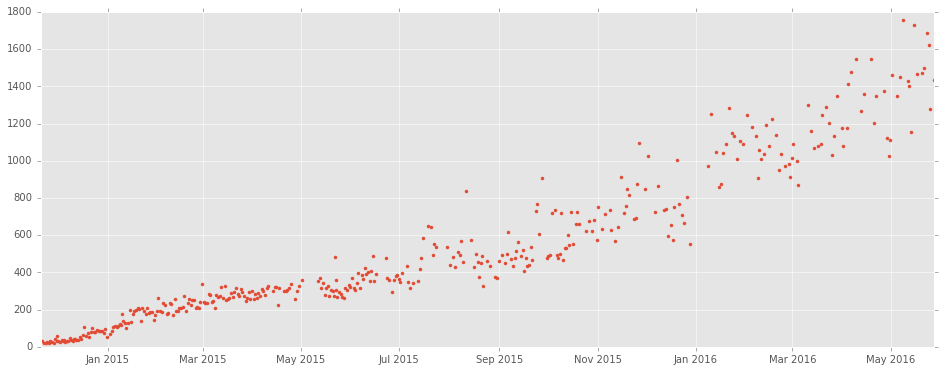

In [16]:
votes = []

for (date, p, _) in polls:
    poll = p['poll']
    votes.append((date, int(poll['votes'])))
    
fig = plt.figure(figsize = [16, 6])
xx, yy = zip(*votes)
plt.plot(xx, yy, '.')
plt.show()

Видно здоровый растущий тренд, но также и монолитность теряется - больше становится разброс.

Чтобы проводить весь дальнейший анализ было удобно и ненакладно проверять новые идеи - создадим DataFrame со всеми необходимыми данными.

In [17]:
df = pd.DataFrame(polls, columns=['date', 'poll', 'item'])

In [18]:
df[0:3]

,date,poll,item
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...


In [19]:
#добавим количество голосовавших и число вариантов ответа
df['votes'] = df['poll'].apply(lambda l: int(l['poll']['votes']))
df['opts'] = df['poll'].apply(lambda l: len(l['poll']['answers']))

In [20]:
df[0:3]

,date,poll,item,votes,opts
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...,1433,5
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...,1281,5
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...,1622,5


In [21]:
print 'Опросов не с 5 вариантами ответа: ', len(df[df['opts'] != 5]), '(т.е. примерно 1/8 от общего числа)'

Опросов не с 5 вариантами ответа:  46 (т.е. примерно 1/8 от общего числа)


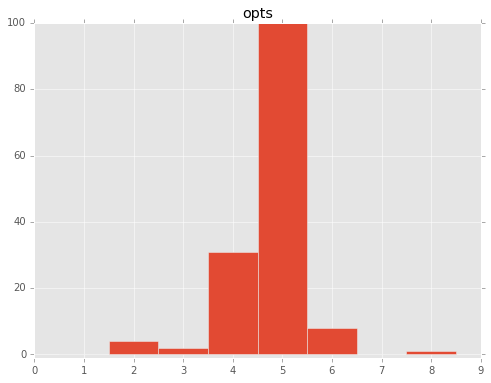

In [22]:
df.hist(column='opts', figsize = [8, 6], bins=np.arange(1,10)-0.5)
plt.xlim(0, 9)
plt.ylim(-1, 100)
plt.show()

Видно, что есть много опросов с 4 вариантами и какая-то мелочь с 2,3,6 и даже один опрос с 8 вариантами. 

In [23]:
print 'Всего голосовало за все время: ', df['votes'].sum()

Всего голосовало за все время:  201595


In [24]:
#добавляем текст от поста с голосованием 
df['text'] = df['item'].apply(lambda l: l['text'])

In [25]:
def get_rates_vector(p):
    rates_v = []
    for ind, opt in enumerate(p['poll']['answers']):
        rates_v.append((opt['rate'], ind+1))
    return rates_v

#добавляем результаты опроса, отсортированные в убывающем порядке, нумерация с 1
df['rates'] = df['poll'].apply(get_rates_vector)
df['rates'] = df['rates'].apply(sorted, reverse=True)

In [26]:
df[0:3]

,date,poll,item,votes,opts,text,rates
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...,1433,5,Переводим №2\n\n1. [id1719186|Александр Марчук...,"[(34.47, 2), (27.91, 1), (15.91, 3), (12.35, 4..."
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...,1281,5,UPD: Переводим №3. \n\n1. [id44532401|Иван Чер...,"[(26.15, 3), (22.4, 1), (19.67, 4), (17.95, 2)..."
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...,1622,5,UPD: Переводим №1. \n\n1. Slate внезапно выясн...,"[(23.67, 1), (22.87, 4), (22.32, 5), (19.73, 2..."


Теперь попробуем распарсить текст поста и достать описание к каждому варианту и ссылку на первоисточник. Сделать это можно не всегда - раньше описание и ссылки были внутри картинок, но таких случаев (назовем их "ленивыми", потому что их можно было бы достать, потратив больше времени) будет не очень много:

In [27]:
def get_opts_description(poll):
    descr = None
    if poll['text'] and poll['text'].count('http') > 3:
        descr = []
        text = poll['text']
        parts = text.split('http')
        links = []
        description = parts[0][:-3]
        for ind, part in enumerate(parts[1:]):
            link = part.split('\n')[0]
            descr.append((ind+1, description, u'http' + link))
            description = part[len(link):-3]        
    if descr:
        descr = [x for x in descr if x[1]]
        descr = zip(range(len(descr)), zip(*descr)[1], zip(*descr)[2])
    return descr

In [28]:
df['descriptions'] = df['item'].apply(get_opts_description)

In [29]:
df[0:3]

,date,poll,item,votes,opts,text,rates,descriptions
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...,1433,5,Переводим №2\n\n1. [id1719186|Александр Марчук...,"[(34.47, 2), (27.91, 1), (15.91, 3), (12.35, 4...","[(0, Переводим №2\n\n1. [id1719186|Александр М..."
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...,1281,5,UPD: Переводим №3. \n\n1. [id44532401|Иван Чер...,"[(26.15, 3), (22.4, 1), (19.67, 4), (17.95, 2)...","[(0, UPD: Переводим №3. \n\n1. [id44532401|Ива..."
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...,1622,5,UPD: Переводим №1. \n\n1. Slate внезапно выясн...,"[(23.67, 1), (22.87, 4), (22.32, 5), (19.73, 2...","[(0, UPD: Переводим №1. \n\n1. Slate внезапно ..."


In [30]:
print 'Ленивых случаев без описания и ссылок: ', df['descriptions'].isnull().sum()

Ленивых случаев без описания и ссылок:  19


Все, вседанные собраны, посмотрим теперь, какие сайты выше ценятся среди участников. Ценность будет определять просто - как сумму голосов, отданную за тот или иной вариант или как среднюю сумму голосов за статьи на сайте:

In [31]:
from urlparse import urlparse
voted_links = {}
count_links = {}

for ind, row in df.iterrows():
    for rate in row['rates']:
        if row['descriptions'] and rate[1] < len(row['descriptions']):
            link = urlparse(row['descriptions'][rate[1]-1][2]).netloc
            if link in voted_links.keys():
                voted_links[link] += rate[0]*row['votes']/100.
                count_links[link] += 1
            else:
                voted_links[link] = rate[0]*row['votes']/100.
                count_links[link] = 1

In [32]:
voted_links_sorted = sorted([(voted_links[l], l) for l in voted_links.keys()], reverse=True)
mean_voted_links_sorted = sorted([(voted_links[l]/count_links[l], l) for l in voted_links.keys()], reverse=True)

In [33]:
print 'Различных источников статей: ', len(voted_links_sorted)

Различных источников статей:  123


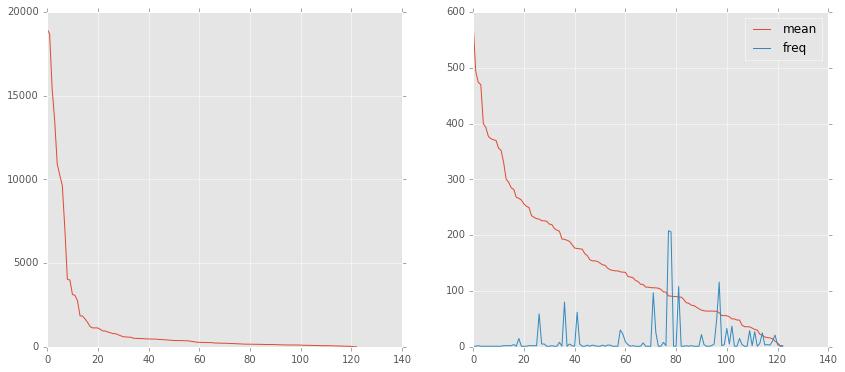

In [34]:
N = len(voted_links_sorted)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=[14, 6])
ax1.plot(range(N), zip(*voted_links_sorted[0:N])[0], '-')
ax2.plot(range(N), zip(*mean_voted_links_sorted[0:N])[0], '-', label='mean')
ax2.plot(range(N), map(lambda l: count_links[l], zip(*mean_voted_links_sorted[0:N])[1]), '-', label='freq')
ax2.legend()
plt.show()

Видно, что в случае с суммарной оценкой около 20 источников поставляют подавляющее количество статей. Если считать среднюю оценку, то распределение гораздо более плавное - но оценку больше половины демонстрируют тоже около 20 источников, причем если смотреть на частоты - то это просто статьи, которые один раз попали в выборку и были хорошо приняты (тогда как большие агрегаторы, например Wired, часто попадают в выборку и усредняются). Посмотрим на топ сайтов для обоих случаев: 

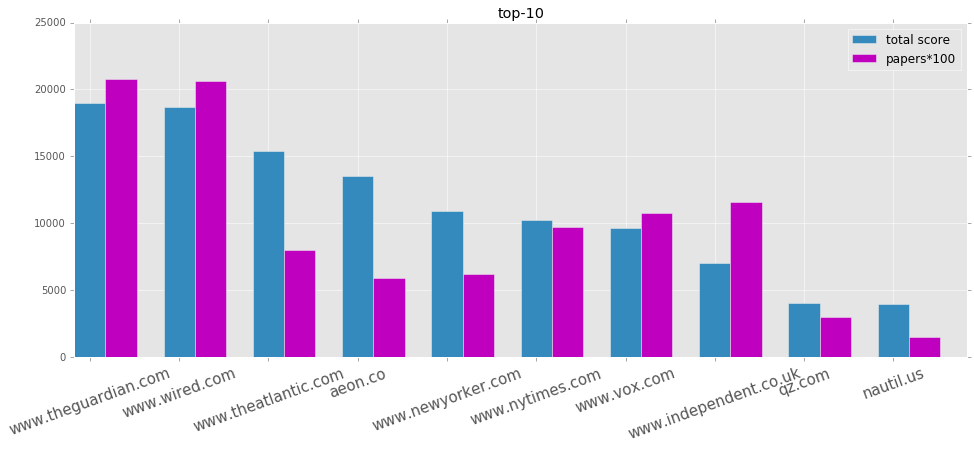

In [35]:
fig = plt.figure(figsize=[16,6])

bar_width = 0.35

plt.bar(np.arange(10), zip(*voted_links_sorted[0:10])[0],  bar_width, label='total score')
plt.bar(np.arange(10)+bar_width, map(lambda l: 100*count_links[l], zip(*voted_links_sorted[0:10])[1]), 
        bar_width, color='m', label='papers*100')

plt.xticks(np.arange(10)+bar_width/2, zip(*voted_links_sorted[0:10])[1], rotation=20., fontsize=15)
plt.title('top-10')
plt.legend()
plt.show()

Для каждого источника показана оценка и число статей в выборке, умноженное на 100. Видно, что The Guardian и Wired вырвались за счет количества статей, а вот The Atlantic и Aeon - скорее качества. Посмотрим остальные 10:

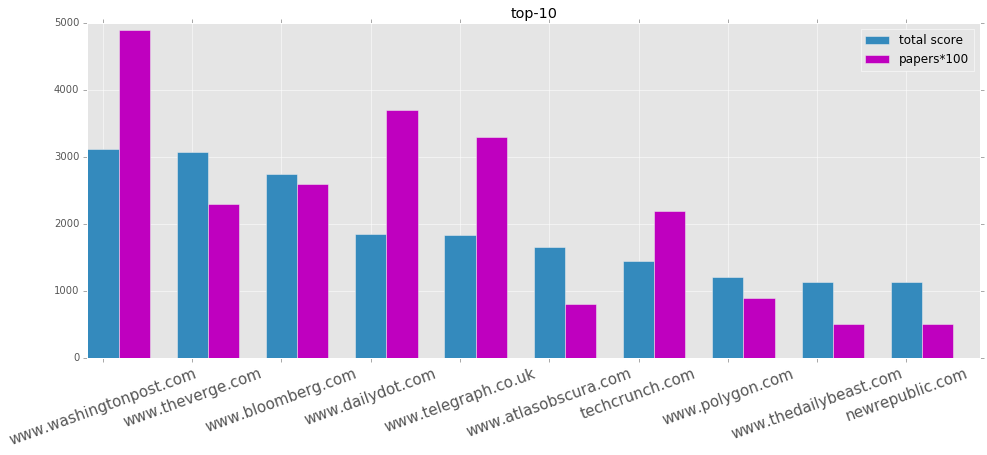

In [36]:
fig = plt.figure(figsize=[16,6])
plt.bar(np.arange(10), zip(*voted_links_sorted[10:20])[0],  bar_width, label='total score')
plt.bar(np.arange(10)+bar_width, map(lambda l: 100*count_links[l], zip(*voted_links_sorted[10:20])[1]), 
        bar_width, color='m', label='papers*100')

plt.xticks(np.arange(10)+bar_width/2, zip(*voted_links_sorted[10:20])[1], rotation=20., fontsize=15)
plt.title('top-10')
plt.legend()
plt.show()

Ничего необычного. Посмотрим теперь на рекордсменов по среднему весу статьи:

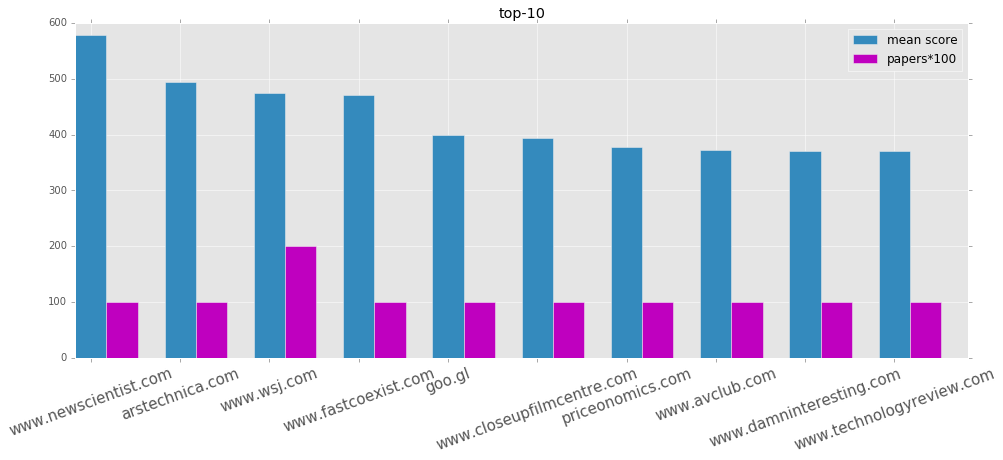

In [47]:
fig = plt.figure(figsize=[16,6])

bar_width = 0.35

plt.bar(np.arange(10), zip(*mean_voted_links_sorted[0:10])[0],  bar_width, label='mean score')
plt.bar(np.arange(10)+bar_width, map(lambda l: 100*count_links[l], zip(*mean_voted_links_sorted[0:10])[1]), 
        bar_width, color='m', label='papers*100')

plt.xticks(np.arange(10)+bar_width/2, zip(*mean_voted_links_sorted[0:10])[1], rotation=20., fontsize=15)
plt.title('top-10')
plt.legend()
plt.show()

Видно, что все эти сайты, за одним исключением, опубликовали одну хорошую статью, которая попала в выборку и за нее активно голосовали (кроме wsj - те опубликовали аж две хорошие статьи).

Вот эти статьи списком:

* cтатья про женщину, что слышит человека прежде, чем тот говорит на [newscientist.com](https://www.newscientist.com/article/dn23813-mindscapes-first-man-to-hear-people-before-they-speak?full=true#.UdblPz5AS6d)

* совсем свежее про устройство интернета от [arstechnica](http://arstechnica.com/information-technology/2016/05/how-the-internet-works-submarine-cables-data-centres-last-mile/)

* две статьи от wsj: [раз](http://www.wsj.com/articles/why-the-west-and-the-rest-got-rich-1463754427?utm_source=pocket&utm_medium=email&utm_campaign=pockethits) - про обогащение запада и [два](http://www.wsj.com/ad/cocainenomics)  - про медельинский наркокартель

* критика капитализма от [fastcoexist](http://www.fastcoexist.com/3056483/welcome-to-the-post-work-economy)

* материал на [aeon](https://goo.gl/gh9iyT), который вставили сокращателем ссылок и который не должен быть в этом списке, об индийском ученом по фамилии Двали и его открытии

* речь о кино в [closeupfilmcentre](https://www.closeupfilmcentre.com/vertigo_magazine/volume-3-issue-3-autumn-2006/a-letter-to-a-boy-from-his-mother/) про то, что снилось людям в те времена, когда кино ещё не изобрели

* финансовая пирамида ККК от [priceonomics](http://priceonomics.com/when-the-kkk-was-a-pyramid-scheme/)

* злодеи-американцы в советском кино от [avclub](http://www.avclub.com/article/villain-gap-why-soviet-movies-rarely-had-american--234481)

* лонгрид о высокотехнологичном ограблении от [damninteresting](http://www.damninteresting.com/the-zero-armed-bandit/)

* [technologyreview](https://www.technologyreview.com/s/601417/the-unbelievable-reality-of-the-impossible-hyperloop/) рассказывает про Hyperloop (ха, это я прислал)

* ну и раз затесался левый aeon - то следующий по списку на 11ом месте лонгрид про крионику в блоге [waitbutwhy](http://waitbutwhy.com/2016/03/cryonics.html) (это наверное лучшее, что я читал)

#### Настала очередь пытаться проверить описанную в начале гипотезу. 
Для ее проверки сначала поймем, как часто вообще выигрывает какой из вариантов:

In [38]:
opt1, opt2, opt3, opt4, opt5 = [],[],[],[],[]
dates = [] 
for (date, p, _) in polls:
    poll = p['poll']
    #берем опросы только длины 5, которых примерно 350 штук
    if len(poll['answers']) == 5:
        answers = poll['answers']
        opt1.append(answers[0]['rate'])
        opt2.append(answers[1]['rate'])
        opt3.append(answers[2]['rate'])
        opt4.append(answers[3]['rate'])
        opt5.append(answers[4]['rate'])
        dates.append(date)

Сравнивать будем проценты. Для начала посмотрим на boxplot:

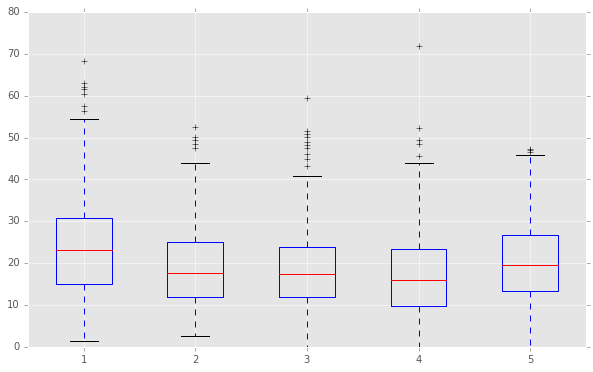

In [39]:
fig = plt.figure(figsize=[10,6])
plt.boxplot([opt1,opt2,opt3,opt4,opt5])
plt.show()

Видно, что медиана с 75% квантиль для первого варианта выше, чем для остальных. Т.е. сами данные похожи на то, что за первый вариант голосуют сильно чаще, хотя пока не ясно, насколько это значимо. Вид распределения у всех вариантов достаточно близок друг к другу, особенно варианты 2-4 (что может свидетельствовать о верности немного измененной гипотезы: побеждают чаще крайние варианты). 

Это было распределение по процентам, посмотрим, как часто выигрывает какой из вариантов:

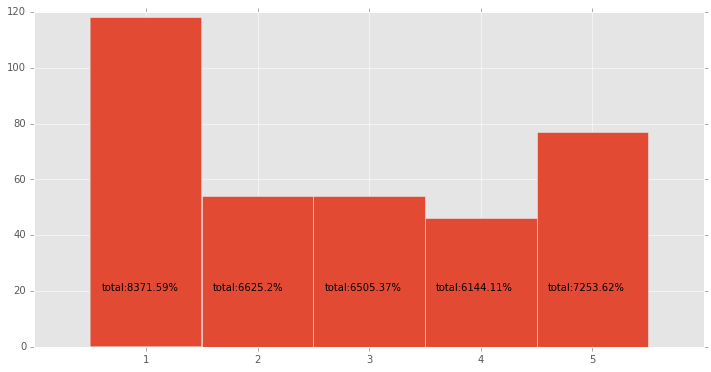

In [40]:
opts = zip(opt1, opt2, opt3, opt4, opt5)
best = []
for o in opts:
    best.append(o.index(max(o))+1)
    
fig = plt.figure(figsize=[12,6])
count_best, _, _ = plt.hist(best, bins=np.arange(1,7)-0.5)
plt.xticks(range(1,6))
for i in range(5):
    plt.text(i+0.6, 20., 'total:{}%'.format(sum([opt1, opt2, opt3, opt4, opt5][i])))
plt.show()

Т.е. более чем в $\frac{1}{3}$ голосований побеждает первый вариант, что опять же очень подозрительно. Попробуем еще посмотреть ранг каждого варианта (ранг - это сумма мест в голосовании):

In [41]:
best_rank = [0,0,0,0,0]
for o in opts:
    q = zip(o, range(1,6))
    q = sorted(q)
    for i in range(5):
        best_rank[q[i][1]-1] += 5-i
best_rank

[897, 1100, 1088, 1160, 990]

Опять же видно, что ранг первого варианта меньше остальных, т.е. первый ответ в голосовании реже других оказывается на последних местах.

Давайте попробуем оценить, насколько значимо статистически наше распределение отличается от ситуации, когда все варинаты одинаково часто оказываются на первом месте - для чего применим критерий $\chi^2$:

In [42]:
from scipy import stats
chis,pvalue = stats.chisquare(count_best, f_exp = [sum(count_best)/5.]*5)
pvalue, chis

(5.0669298134213526e-10, 49.295128939828082)

Т.е. $\chi^2$-критерий еще раз подтверждает то, что видно выше - ситуация значимо отличается от равномерной.

Для еще одной проверки гипотезы нам понадобится проанализировать слова, т.е. какие темы или направления больше интересуют людей в паблике, а какие меньше. Чтобы различать слова вида 'мозг', 'мозга', 'мозги' и 'мозговой', слова надо приводить к нормальной форме, для чего используется морфологический анализатор (тут [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization)). К сожалению, задача приведения почти всегда решается неоднозначно, но я постараюсь это учитывать.

In [191]:
morph = pymorphy2.MorphAnalyzer()

In [196]:
#пример разбора и неоднозначности, а также вероятность в русском языке той или иной формы
for form in morph.parse(u'стали'):
    print form.normal_form, form.tag, form.score

стать VERB,perf,intr plur,past,indc 0.984662
сталь NOUN,inan,femn sing,gent 0.003067
сталь NOUN,inan,femn sing,datv 0.003067
сталь NOUN,inan,femn sing,loct 0.003067
сталь NOUN,inan,femn plur,nomn 0.003067
сталь NOUN,inan,femn plur,accs 0.003067


In [199]:
#еще пример разбора
for form in morph.parse(u'Илон'):
    print form.normal_form, form.tag, form.score

илона NOUN,anim,femn,Name plur,gent 0.333333333333
илона NOUN,anim,femn,Name plur,accs 0.333333333333
илона NOUN,anim,femn,Name sing,voct,Infr 0.333333333333


In [54]:
import unicodedata
import sys


tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl)

Интересовать нас будут только существительные и те слова, у которых анализатор не смог определить часть речи (в основном всякое латиницей). Для каждого слова в описании из текста поста и из описания собственно варианта ответа мы будем учитывать, к кому ответу он относится и добавлять ему тот вес, сколько получил соответствующий вариант - то же самое, что с ссылками раньше, только со словами.  Также будет считаться количество вхождений слова, чтобы поом посчитать средний вес:

In [200]:
%%time

wwords = {}
big_bag = {}
#если хочется не только существительные - можно раскомментировтаь строку ниже и закомментировать следующую
# good_pos = ['NOUN', 'ADJF', 'ADJS', 'VERB', 'INFN', 'PRTF', 'PRTS']
good_pos = ['NOUN']
variants = {}
words_sum = 0

for index, row in df.iterrows():
    if row['descriptions']:
        answers = row['poll']['poll']['answers']
        for (ind, descr, link_) in row['descriptions'][0:len(answers)]:
            text = descr + answers[ind-1]['text']
            bag = remove_punctuation(text).replace('\n', '').split(' ')
            words_sum += len(bag)
            votes = int(answers[ind]['votes'])
            part_of_speech_only = []
            for word in bag:
                if len(word) > 2:
                    for form in morph.parse(word):
                        part_of_speech_only.append((form.normal_form, form.tag.POS, word))
            forms = part_of_speech_only
            for form in set(forms):
                key = None
                if not form[1]:
                    key = form[0] + ', NONE'
                if form[1] and form[1] in good_pos:
                    key = form[0] + ', ' + form[1]
                if key:
                    
                    if key in wwords.keys():
                        wwords[key] += votes
                    else:
                        wwords[key] = votes
                    
                    if key in variants.keys():
                        variants[key].append(form[2])
                    else:
                        variants[key] = [form[2]]

                    if key in big_bag.keys():
                        big_bag[key] += 1
                    else:
                        big_bag[key] = 1

Wall time: 28.5 s


In [201]:
print 'Форм слов: ', len(wwords)

Форм слов:  7536


In [202]:
#формируем пары слово-вес и сортируем по весу
wwords_list = [[wwords[key], key] for key in wwords.keys()]
wwords_list = sorted(wwords_list, reverse=True)

Также заведем небольшой список слов, которые предположительно могут получать большой вес:

In [203]:
words_of_interest = [u'секс, NOUN', u'порно, NOUN',  u'девайс, NOUN',  u'маска, NOUN',  u'технология, NOUN',  
                     u'политика, NOUN', u'запад, NOUN',  u'учёный, NOUN',  u'исследование, NOUN',  u'история, NOUN',
                     u'россия, NOUN', u'будущее, NOUN', u'труп, NOUN', u'мозг, NOUN']

In [208]:
print u'{:20s} {}\t {}\t {}'.format(u'Слово', u'Вес', u'#', u'Вес/#')
print u'----------------------------------------------'
for word in words_of_interest:
    print u'{:20s} {}\t {}\t {:.0f}'.format(word, wwords[word], big_bag[word], wwords[word]/float(big_bag[word]))

Слово                Вес	 #	 Вес/#
----------------------------------------------
секс, NOUN           1372	 5	 274
порно, NOUN          1475	 11	 134
девайс, NOUN         1706	 8	 213
маска, NOUN          1865	 9	 207
технология, NOUN     5078	 30	 169
политика, NOUN       5099	 36	 142
запад, NOUN          4848	 37	 131
учёный, NOUN         9809	 70	 140
исследование, NOUN   4496	 29	 155
история, NOUN        30121	 195	 154
россия, NOUN         9434	 81	 116
будущее, NOUN        8589	 56	 153
труп, NOUN           1062	 9	 118
мозг, NOUN           4636	 26	 178


Видно, что все эти слова имели больше пяти вхождений в текст, а 'история' - так вообще в среднем в каждом втором посте встречалось. Давайте посмотрим на топ слов по весам и их частоты, а также попали ли туда эти слова: 

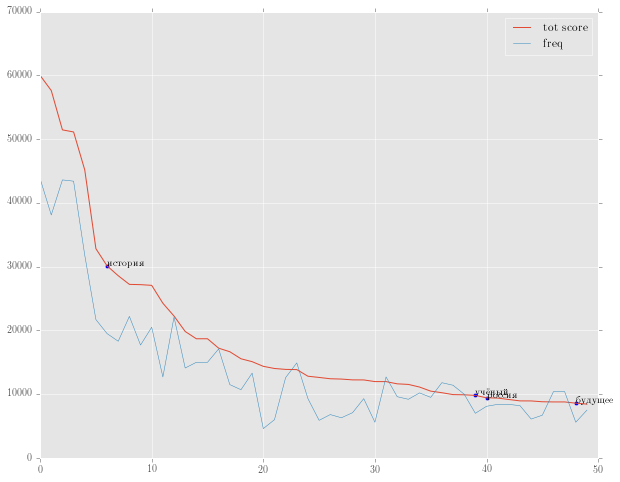

In [210]:
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex',unicode=True)
rc('text.latex',preamble='\usepackage[utf8]{inputenc}')
rc('text.latex',preamble='\usepackage[russian]{babel}')


N = 50
fiig = plt.figure(figsize=[10,8])
plt.plot(range(N), zip(*wwords_list)[0][0:N], '-', label='tot score')
plt.plot(range(N), map(lambda l: 100*big_bag[l], zip(*wwords_list)[1][0:N]), '-', lw=0.5, label='100*freq')
for w in words_of_interest:
    ind = wwords_list.index([wwords[w], w])
    if ind < N:
        plt.scatter([ind], [wwords[w]])
        plt.text(ind, wwords[w], w[:w.index(',')])
plt.xlim(0, N)
plt.legend()
plt.show()

Видно, что использовать суммарный вес слова в качестве его значимости - бесполезно, т.к. больше набирают те слова, которые просто больше встречаются. Поэтому перейдем к среднему весу слова:

In [211]:
#опять пары, но со средним весом
wwords_list = [[wwords[key]/float(big_bag[key]), key] for key in wwords.keys()]
wwords_list = sorted(wwords_list, reverse=True)

In [213]:
print u'{:20s} {}\t {}'.format(u'Слово', u'Вес', u'#')
print u'----------------------------------------------'
for (weight, w) in wwords_list[0:20]:
    print u'{:30s} {:.0f}\t {}'.format(w, weight, big_bag[w])

Слово                Вес	 #
----------------------------------------------
первуюв, NOUN                  834	 1
id2976692|anton, NONE          706	 2
angel, NONE                    706	 2
хоффман, NOUN                  691	 1
обусловлен2, NONE              691	 1
корн, NOUN                     691	 1
№1вота, NOUN                   677	 1
фейк5, NONE                    677	 1
иллинойс, NOUN                 677	 1
№1в, NONE                      645	 1
институт, NOUN                 645	 1
воспоминания5, NONE            645	 1
today, NONE                    645	 1
psychology, NONE               645	 1
dêtre, NONE                    645	 1
экономику5, NONE               626	 1
переврала5, NONE               607	 1
говорить5, NONE                578	 1
сахар, NOUN                    576	 1
питание, NOUN                  576	 1


Видно, что максимальный средний вес набрали слова, которые плохо распарсились и встретились один раз в варианте с большим числом голосов. Чтобы получить более значимый результат, надо слова с маленькими частотами убрать из рассмотрения. Чтобы понять необходимый порог - посмотрим на гистограмму числа вхождений слов:

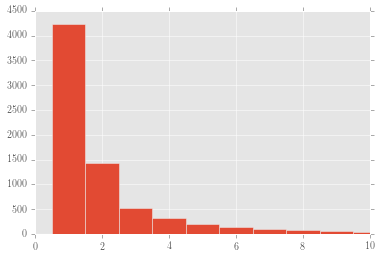

In [217]:
plt.hist(big_bag.values(), bins=np.arange(0, 450, 1)-0.5)
plt.xlim(0, 10)
plt.show()

Видно, что большинство слов имеет по 1-2 вхождения. Для уверенности будем считать, что слово хотя бы с 5 вхождениями можно уже примерно оценить по значимости:

In [231]:
dbwwords_list = []
for (weight, w) in wwords_list:
    if big_bag[w] > 4:
        dbwwords_list.append((weight, w))

dbwwords_list = sorted(dbwwords_list, reverse=True)

In [232]:
print 'Слов с частотой >=5: ', len(dbwwords_list)

Слов с частотой >=5:  1037


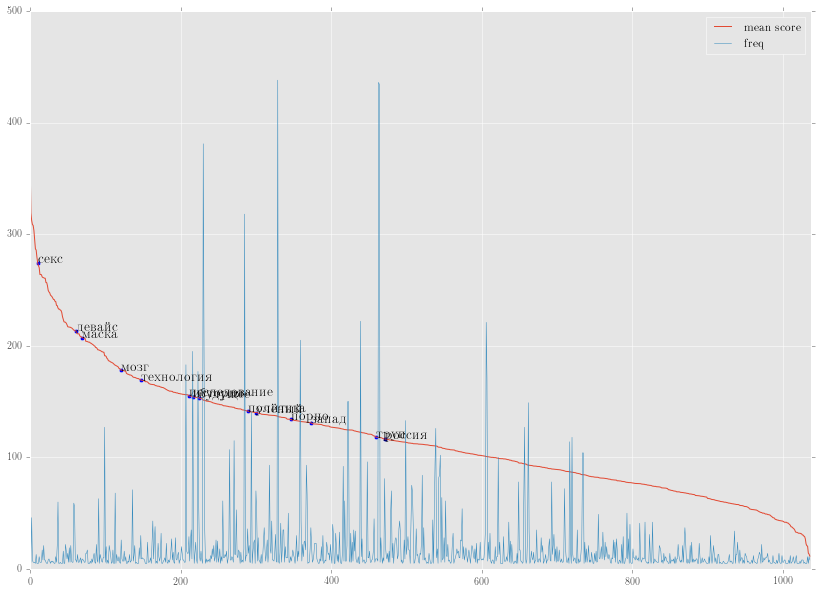

In [247]:
N = len(dbwwords_list)
fig = plt.figure(figsize=[14,10])
plt.plot(range(N), zip(*dbwwords_list)[0], '-', lw=1., label='mean score')
plt.plot(range(N), map(lambda l: big_bag[l], zip(*dbwwords_list)[1]), '-', lw=0.5, label='freq')
for w in words_of_interest:
    ind = dbwwords_list.index((wwords[w]/float(big_bag[w]), w))
    if ind < N:
        plt.scatter([ind], [wwords[w]/float(big_bag[w])], s=20.)
        plt.text(ind, wwords[w]/float(big_bag[w]), w[:w.index(',')], fontsize=15)
plt.xlim(0, N+1)
plt.ylim(0, 500)
plt.legend()
plt.show()

Видно, что все равно в топе слова с малой частотой, но они теперь не "мусорные". Также видно, что все слова из списка интересных попали в большую половину. Посмотрим на топ-50: 

In [250]:
print u'{:30s} {}\t {}'.format(u'Слово', u'Вес', u'#')
print u'----------------------------------------------'
for (weight, w) in dbwwords_list[0:50]:
    print u'{:30s} {:.0f}\t {}'.format(w, weight, big_bag[w])

Слово                          Вес	 #
----------------------------------------------
№11, NONE                      365	 5
главред, NOUN                  319	 6
upd, NONE                      312	 46
id1719186|александр, NOUN      309	 8
философия, NOUN                308	 6
животное, NOUN                 303	 6
марчук, NOUN                   295	 6
id220239905|мартина, NOUN      287	 5
nautilus, NONE                 286	 13
мекка, NOUN                    279	 5
секс, NOUN                     274	 5
осуждённый, NOUN               272	 5
demon, NONE                    270	 11
предложок, NOUN                264	 6
предложка, NOUN                264	 6
обман, NOUN                    264	 6
общество, NOUN                 262	 17
старение, NOUN                 261	 8
профессор, NOUN                261	 21
крионика, NOUN                 260	 8
крионик, NOUN                  260	 8
ограбление, NOUN               257	 6
золотой, NOUN                  257	 5
афиша, NOUN                    254	 

Видно, что есть немного мусора (что это за '№11' с 5 вхождениями?) и пары слов, где анализатор пробуксовывает - "предложок" и "предложка", "крионик" и "крионика", "цвета" и "цвет". Тем не менее, выглядит список довольно обоснованно. Построим соответствующий wordcloud:

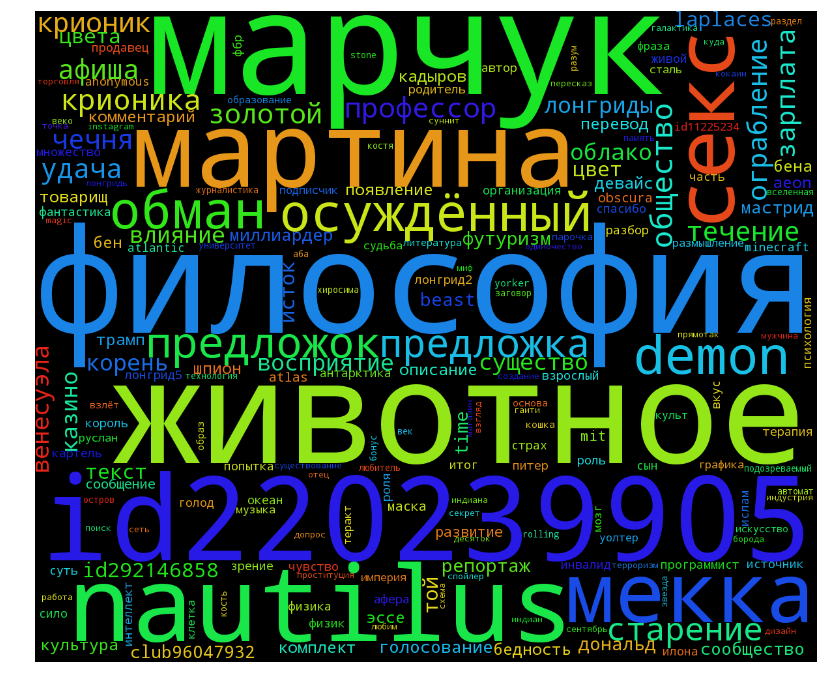

In [253]:
from wordcloud import WordCloud

wc_text = ''
#выкидываем первые 4 слова
for (weight, w) in dbwwords_list[4:]:
    wc_text += (' '+w[:w.index(',')])*int(weight)

fig = plt.figure(figsize=(14, 18))
wordcloud = WordCloud(background_color='black',
                          width=1200,
                          height=1000).generate(wc_text)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Да, видимо я предлагаю много годноты в предложенные статьи. Возможно стоило также выкинуть слова с большой частотой (чтобы всякие "текст" и "upd" не попадали в топ) и сделать порог выше (чтобы повысить уверенность и убрать свою фамилию), но это не так принципиально. 

Теперь то, для чего это делалось - проверка гипотезы. Чтобы косвенно проверить именно мою гипотезу, а не альтернативную (например, что редакторы ставят чаще самое интересное в начало), я отберу слова, которые определяют вес варианта, и посмотрю на их распределение между вариантами. Если распределения будут похожими друг на друга - то это будет свидетельство в пользу того, что большинство невнимательно читает текст и выбирает первый вариант (только свидетельство, нив коем случае не доказательство!).

Посмотрим, какая часть слов дает больший вклад в вес варианта:

In [267]:
accum_weight = 0
accum_weights = []
for (weight, w) in dbwwords_list:
    accum_weight += weight
    accum_weights.append(accum_weight)

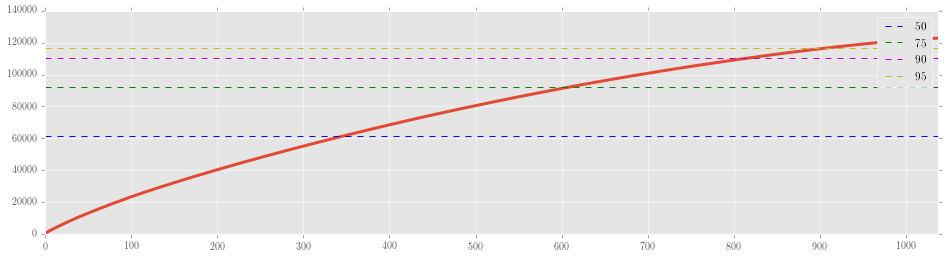

In [272]:
fig = plt.figure(figsize=[16,4])
plt.plot(range(len(dbwwords_list)), accum_weights, '-', lw=3.)
plt.axhline(y = accum_weight*0.50, ls='--', label='50%', color='b')
plt.axhline(y = accum_weight*0.75, ls='--', label='75%', color='g')
plt.axhline(y = accum_weight*0.90, ls='--', label='90%', color='m')
plt.axhline(y = accum_weight*0.95, ls='--', label='95%', color='y')
plt.legend()
plt.xticks(range(0, N, 100))
plt.xlim(0, N)
plt.show()

Видно, что 75% вклад (без учета частот!) в суммарный вес дает половина всех слов, т.е. 600 штук. Отберем эти слова и посмотрим на их взвешенное распределение по вариантам в голосовании:

In [273]:
plausible_nouns = [w[1] for w in dbwwords_list[0:600]]

In [274]:
%%time
opts = [[],[],[],[],[],[],[],[]]

for index, row in df.iterrows():
    if row['descriptions']:
        answers = row['poll']['poll']['answers']
        for (ind, descr, link_) in row['descriptions'][0:len(answers)]:
            text = descr + answers[ind-1]['text']
            bag = remove_punctuation(text).replace('\n', '').split(' ')
            words_sum += len(bag)
            votes = int(option['votes'])
            part_of_speech_only = []
            for word in bag:
                if len(word) > 2:
                    for form in morph.parse(word):
                        part_of_speech_only.append((form.normal_form, form.tag.POS))
            forms = set(part_of_speech_only)
            weight = 0
            for form in forms:
                key = None
                if not form[1]:
                    key = form[0] + ', NONE'
                if form[1] and form[1] in good_pos:
                    key = form[0] + ', ' + form[1]
                if key and key in plausible_nouns:
#                     print key
                    weight += wwords[key]
            opts[ind].append(weight)

Wall time: 14.8 s


In [275]:
for opt in opts:
    print len(opt)

376
376
376
376
350
7
0
0


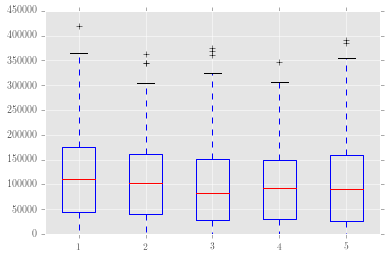

In [276]:
plt.boxplot(opts[0:5])
plt.show()

Распределение по вариантам. Видно, что все распределения выровнялись (см. например варианты 1,2,5) и количество выбросов стало сильно меньше. Это косвенно подтверждает высказанное в начале исследования предположение. 